In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import zero_one_loss, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Loading the processed dataset
df = pd.read_csv('LendingClub_processed.csv')
df.shape

(132460, 54)

In [3]:
# Loading the data dictionary
pd.set_option('max_colwidth', 1200) # controls output width; might need adjustment
data_dictionary = pd.read_csv('LCDataDictionary.csv') # Loading in the data dictionary
data_dictionary = data_dictionary.rename(columns={'LoanStatNew': 'name', 'Description': 'description'})

# generate preview names + dtypes + first values + descriptions
df_dtypes = pd.DataFrame(df.dtypes,columns=['dtypes'])
df_dtypes = df_dtypes.reset_index()
df_dtypes['name'] = df_dtypes['index']
df_dtypes = df_dtypes[['name','dtypes']]
df_dtypes['first value'] = df.loc[0].values
preview = df_dtypes.merge(data_dictionary, on='name',how='left')

## Categorical variables

In [4]:
# Generate list of the categorical variables
categorical_features = list(df.columns[df.dtypes == 'object'])
categorical_features_preview = preview[preview["name"].isin(categorical_features)]

# Unique values of each categorical variable
unique_vals = []
unique_counts = []
for feature in categorical_features:
    u = np.sort(df[feature].unique())
    unique_vals.append(str(u).replace('\n', ''))
    unique_counts.append(len(u))


categorical_features_preview.insert(4, "number of unique values", unique_counts, True)
categorical_features_preview.insert(5, "unique values", unique_vals, True)
categorical_features_preview = categorical_features_preview.drop(columns=['dtypes', 'first value'])
categorical_features_preview

,name,description,number of unique values,unique values
1,term,The number of payments on the loan. Values are in months and can be either 36 or 60.,2,[' 36 months' ' 60 months']
3,grade,LC assigned loan grade,7,['A' 'B' 'C' 'D' 'E' 'F' 'G']
4,sub_grade,LC assigned loan subgrade,35,['A1' 'A2' 'A3' 'A4' 'A5' 'B1' 'B2' 'B3' 'B4' 'B5' 'C1' 'C2' 'C3' 'C4' 'C5' 'D1' 'D2' 'D3' 'D4' 'D5' 'E1' 'E2' 'E3' 'E4' 'E5' 'F1' 'F2' 'F3' 'F4' 'F5' 'G1' 'G2' 'G3' 'G4' 'G5']
5,emp_title,The job title supplied by the Borrower when applying for the loan.*,49278,[' \tOFFICE MANAGER/MEDICAL ASSISTANT' ' Ag' ' Registered nurse ' ... 'zanjero' 'zone lead' 'zone supervisor']
6,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.,11,['1 year' '10+ years' '2 years' '3 years' '4 years' '5 years' '6 years' '7 years' '8 years' '9 years' '< 1 year']
7,home_ownership,"The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.",4,['ANY' 'MORTGAGE' 'OWN' 'RENT']
9,verification_status,"Indicates if income was verified by LC, not verified, or if the income source was verified",3,['Not Verified' 'Source Verified' 'Verified']
11,purpose,A category provided by the borrower for the loan request.,12,['car' 'credit_card' 'debt_consolidation' 'home_improvement' 'house' 'major_purchase' 'medical' 'moving' 'other' 'renewable_energy' 'small_business' 'vacation']
12,zip_code,The first 3 numbers of the zip code provided by the borrower in the loan application.,888,['007xx' '008xx' '009xx' '010xx' '011xx' '012xx' '013xx' '014xx' '015xx' '016xx' '017xx' '018xx' '019xx' '020xx' '021xx' '022xx' '023xx' '024xx' '025xx' '026xx' '027xx' '028xx' '029xx' '030xx' '031xx' '032xx' '033xx' '034xx' '035xx' '036xx' '037xx' '038xx' '039xx' '040xx' '041xx' '042xx' '043xx' '044xx' '045xx' '046xx' '047xx' '048xx' '049xx' '050xx' '051xx' '052xx' '053xx' '054xx' '056xx' '057xx' '058xx' '059xx' '060xx' '061xx' '062xx' '063xx' '064xx' '065xx' '066xx' '067xx' '068xx' '069xx' '070xx' '071xx' '072xx' '073xx' '074xx' '075xx' '076xx' '077xx' '078xx' '079xx' '080xx' '081xx' '082xx' '083xx' '084xx' '085xx' '086xx' '087xx' '088xx' '089xx' '090xx' '091xx' '092xx' '094xx' '096xx' '097xx' '098xx' '100xx' '101xx' '102xx' '103xx' '104xx' '105xx' '106xx' '107xx' '108xx' '109xx' '110xx' '111xx' '112xx' '113xx' '114xx' '115xx' '116xx' '117xx' '118xx' '119xx' '120xx' '121xx' '122xx' '123xx' '124xx' '125xx' '126xx' '127xx' '128xx' '129xx' '130xx' '131xx' '132xx' '133xx' '134xx' '135xx' '136xx' '137xx' '138xx' '139xx' '140xx' '141xx' '142xx' '143xx' '144xx' '145xx' '146xx' '147xx' '148xx' '149xx' '150xx' '151xx' '152xx' '153xx' '154xx' '155xx' '156xx' '157xx' '158xx' '159xx' '16...
13,addr_state,The state provided by the borrower in the loan application,50,['AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI' 'ID' 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS' 'MT' 'NC' 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD' 'TN' 'TX' 'UT' 'VA' 'VT' 'WA' 'WI' 'WV' 'WY']


In [5]:
# nominal variables:
df['term'] = df['term'].factorize()[0]
df['home_ownership']= df['home_ownership'].factorize()[0]
df['verification_status'] = df['verification_status'].factorize()[0]
df['purpose'] = df['purpose'].factorize()[0]
df['addr_state'] = df['addr_state'].factorize()[0]

# Nominal variables with too many unique values:
df["emp_title"] = pd.util.hash_array(df["emp_title"].to_numpy())
df["zip_code"] = pd.util.hash_array(df["zip_code"].to_numpy())

# Ordinal variables:
mapping_dictionary = {"grade":{"A":0, "B":1, "C":2, "D":3, "E":4, "F":5, "G":6},
                      "sub_grade":{"A1":0, "A2":0.2, "A3":0.4, "A4":0.6, "A5":0.8, "B1":1, "B2":1.2, "B3":1.4, "B4":1.6, "B5":1.8, "C1":2, "C2":2.2, "C3":2.4, "C4":2.6, "C5":2.8, "D1":3, "D2":3.2, "D3":3.4, "D4":3.6, "D5":3.8, "E1":4, "E2":4.2, "E3":4.4, "E4":4.6, "E5":4.8, "F1":5, "F2":5.2, "F3":5.4, "F4":5.6, "F5":5.8, "G1":6, "G2":6.2, "G3":6.4, "G4":6.6, "G5":6.8},
                      "emp_length":{"< 1 year":0, "1 year":1, "2 years":2, "3 years":3, "4 years":4, "5 years":5, "6 years":6, "7 years":7, "8 years":8, "9 years":9, "10+ years":10}}
df = df.replace(mapping_dictionary)
df.shape

(132460, 54)

In [6]:
# Categorical features after the encoding process:
categorical_features_after_encoding = preview[preview["name"].isin(categorical_features)]

# Unique values of each categorical variable
unique_vals = []
unique_counts = []
for feature in categorical_features:
    u = np.sort(df[feature].unique())
    unique_vals.append(str(u).replace('\n', ''))
    unique_counts.append(len(u))


categorical_features_after_encoding.insert(4, "number of unique values", unique_counts, True)
categorical_features_after_encoding.insert(5, "unique values", unique_vals, True)
categorical_features_after_encoding = categorical_features_after_encoding.drop(columns=['dtypes', 'first value'])
categorical_features_after_encoding

,name,description,number of unique values,unique values
1,term,The number of payments on the loan. Values are in months and can be either 36 or 60.,2,[0 1]
3,grade,LC assigned loan grade,7,[0 1 2 3 4 5 6]
4,sub_grade,LC assigned loan subgrade,35,[0. 0.2 0.4 0.6 0.8 1. 1.2 1.4 1.6 1.8 2. 2.2 2.4 2.6 2.8 3. 3.2 3.4 3.6 3.8 4. 4.2 4.4 4.6 4.8 5. 5.2 5.4 5.6 5.8 6. 6.2 6.4 6.6 6.8]
5,emp_title,The job title supplied by the Borrower when applying for the loan.*,49278,[ 889954848215734 1294130214511985 1426969337986789 ... 18445585171336177713 18446135327641254784 18446260370742669998]
6,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.,11,[ 0 1 2 3 4 5 6 7 8 9 10]
7,home_ownership,"The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.",4,[0 1 2 3]
9,verification_status,"Indicates if income was verified by LC, not verified, or if the income source was verified",3,[0 1 2]
11,purpose,A category provided by the borrower for the loan request.,12,[ 0 1 2 3 4 5 6 7 8 9 10 11]
12,zip_code,The first 3 numbers of the zip code provided by the borrower in the loan application.,888,[ 21790586110310201 34270912556226229 64926776796455154 87902297505678924 89081095216588015 100134030542127631 102344409368642229 107578211114037188 113746197238040072 139150927751637495 202749356586235469 221644318720026424 230980542625300915 247658604630824740 291748804832579107 296426208491996782 312506582572167962 377171329470615400 377736873516018277 383889691565038515 392199995804386076 439622774277188546 440746258985335869 499312924524761117 520806504328691063 529967424865619301 566366119269911297 585287359397555728 608095735962517374 609009844950137539 638418894600571116 648815337226148563 653196138164406886 706358553687349831 759672468991209277 787148819006203680 802696509373929871 831589054250173212 940399550650366826 951673718467093646 964089446400847444 974310664750927652 982288293326957715 1023712669913023464 1032960261974323082 1052079129486545137 1084574357015907644 1088395000220658999 1118022328251571422 1127740035340771021 1130262158509339795 1132973373910349220 1133830161017439335 1150738970604539007 1152667873466865061 1154090654322280078 115516312403309652...
13,addr_state,The state provided by the borrower in the loan application,50,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]


## Split data into training set and test set

In [7]:
#Splitting the data, 70% train set, 30% test set
training_set_X, test_set_X = train_test_split(df, test_size=0.3)

#Splitting the sets, X sets and Y sets
drop_list = ['loan_status']
training_set_Y = training_set_X['loan_status']
test_set_Y = test_set_X['loan_status']

#Dropping the Y column from the X sets
training_set_X.drop(drop_list, axis=1, inplace=True)
test_set_X.drop(drop_list, axis=1, inplace=True)

print("Training set: " + " X: " + str(training_set_X.shape) + ";  Y: "+str(training_set_Y.shape))
print("Test set: " + " X: " + str(test_set_X.shape) + ";  Y: "+str(test_set_Y.shape))

Training set:  X: (92722, 53);  Y: (92722,)
Test set:  X: (39738, 53);  Y: (39738,)


In [8]:
# Showing that Dataset proportions were maintained:
c = df['loan_status'].value_counts()
p = c/(c[0]+c[1])
print("Original full set: unique vals: ", [0,1], " counts: ", [c[0], c[1]], " proportions: ", [p[0], p[1]])

u, c = np.unique(np.array(training_set_Y), return_counts=True)
print("Training set:      unique vals: ", u, "  counts: ", c, "   proportions: ", c/(c[0]+c[1]))
u, c = np.unique(np.array(test_set_Y), return_counts=True)
print("Test set:          unique vals: ", u, "  counts: ", c, "   proportions: ", c/(c[0]+c[1]))

Original full set: unique vals:  [0, 1]  counts:  [30307, 102153]  proportions:  [0.22880114751623132, 0.7711988524837687]
Training set:      unique vals:  [0 1]   counts:  [21279 71443]    proportions:  [0.22949246 0.77050754]
Test set:          unique vals:  [0 1]   counts:  [ 9028 30710]    proportions:  [0.22718808 0.77281192]


## Scaling

In [9]:
scaler = StandardScaler()
scaler.fit(training_set_X)
training_set_X = scaler.transform(training_set_X)
test_set_X = scaler.transform(test_set_X)

print("Training set: " + str(training_set_X.shape))
print("Test set: " + str(test_set_X.shape))

Training set: (92722, 53)
Test set: (39738, 53)


## Exporting the split sets to CSVs for future use
(commented because the split needs to be saved only once)

In [10]:
# pd.DataFrame(training_set_X).to_csv('training_set_X.csv', index=False)
# pd.DataFrame(training_set_Y).to_csv('training_set_Y.csv', index=False)
# pd.DataFrame(test_set_X).to_csv('test_set_X.csv', index=False)
# pd.DataFrame(test_set_Y).to_csv('test_set_Y.csv', index=False)

## Importing the training and test sets

In [11]:
# Loading the datasets
training_set_X = pd.read_csv('training_set_X.csv').to_numpy()
training_set_Y = pd.read_csv('training_set_Y.csv').to_numpy().ravel()
test_set_X = pd.read_csv('test_set_X.csv').to_numpy()
test_set_Y = pd.read_csv('test_set_Y.csv').to_numpy().ravel()

# Save feature names because standardScaler removes them
feature_names = pd.read_csv('LendingClub_processed.csv', nrows=1).columns.tolist()
feature_names.remove('loan_status')
feature_names = np.array(feature_names)

print("Total amount of features: " + str(len(feature_names)))
print("Training set: " + " X: " + str(training_set_X.shape) + ";  Y: "+str(training_set_Y.shape))
print("Test set: " + " X: " + str(test_set_X.shape) + ";  Y: "+str(test_set_Y.shape))

Total amount of features: 53
Training set:  X: (92722, 53);  Y: (92722,)
Test set:  X: (39738, 53);  Y: (39738,)


In [12]:
# Showing that Dataset proportions were maintained (after the split) for loan status:
c = df['loan_status'].value_counts()
p = c/(c[0]+c[1])
print("Original full set: unique vals: ", [0,1], " counts: ", [c[0], c[1]], " proportions: ", [p[0], p[1]])

u, c = np.unique(np.array(training_set_Y), return_counts=True)
print("Training set:      unique vals: ", u, "  counts: ", c, "   proportions: ", c/(c[0]+c[1]))
u, c = np.unique(np.array(test_set_Y), return_counts=True)
print("Test set:          unique vals: ", u, "  counts: ", c, "   proportions: ", c/(c[0]+c[1]))

Original full set: unique vals:  [0, 1]  counts:  [30307, 102153]  proportions:  [0.22880114751623132, 0.7711988524837687]
Training set:      unique vals:  [0 1]   counts:  [21192 71530]    proportions:  [0.22855417 0.77144583]
Test set:          unique vals:  [0 1]   counts:  [ 9115 30623]    proportions:  [0.22937742 0.77062258]


## Ridge regression

#### Finding the best lambda

In [13]:
ridge = LogisticRegression(penalty='l2', fit_intercept=True, max_iter=100)

lambdas = 10**np.linspace(10, -10, 100) # 10 to the power of 100 evenly spaced numbers over [10, -10]
accuracy_lambdas = [] # accuracy of predictions for each lambda
max_accuracy = 0; max_acc_index = 0

for idx, l in enumerate(lambdas):
    ridge.set_params(C = l)
    ridge.fit(training_set_X, training_set_Y)
    predictions = (ridge.predict(training_set_X) >= 0.5).astype(int)  # if prediction > 0.5 round it to 1, else to 0

    acc = (1 - zero_one_loss(training_set_Y, predictions)) * 100    # get the sum of correctly classified objects
    accuracy_lambdas.append(acc)

    [max_accuracy, max_acc_index] = [acc, idx] if acc>max_accuracy else [max_accuracy, max_acc_index] # Keep track of max accuracy

print('Accurracy for each lambda: ' + str(accuracy_lambdas[0:2])[:-1] + '...' + str(accuracy_lambdas[len(accuracy_lambdas)-2 : len(accuracy_lambdas)])[1:])
print('Max accuracy: Lambda = ' + str(lambdas[max_acc_index]) + '  accuracy: ' + str(accuracy_lambdas[max_acc_index]))

Accurracy for each lambda: [77.75285261318781, 77.75285261318781...77.14458273117492, 77.14458273117492]
Max accuracy: Lambda = 0.0018738174228603867  accuracy: 77.7755009598585


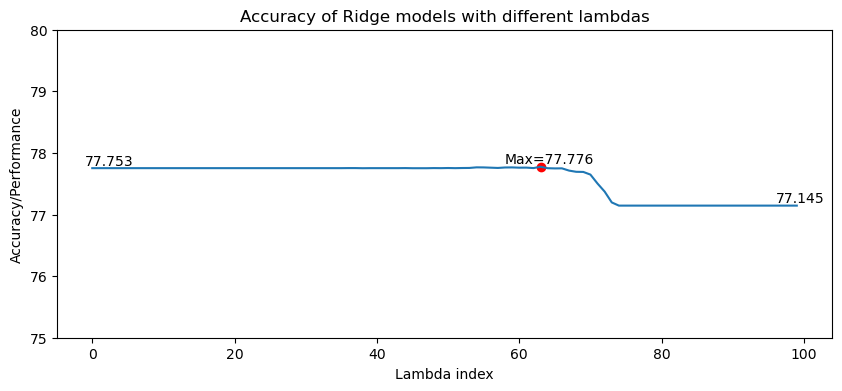

Lambda values: ['10^10.0', '10^9.798', '10^9.596', '10^9.394'...'10^-9.394', '10^-9.596', '10^-9.798', '10^-10.0']
Max accuracy: Lambda = 0.0018738174228603867  accuracy: 77.7755009598585


In [14]:
# Plot performances:
plt.figure(figsize=(10, 4))
plt.ylim([75, 80])
plt.plot(range(len(lambdas)), accuracy_lambdas)
plt.scatter(max_acc_index, max_accuracy,  color="red") # Max accuracy point

plt.text(0-1, accuracy_lambdas[0]+0.05, str(round(accuracy_lambdas[0], 3)))
plt.text(max_acc_index-5, accuracy_lambdas[max_acc_index]+0.05, 'Max='+str(round(accuracy_lambdas[max_acc_index], 3)))
plt.text(len(lambdas)-4, accuracy_lambdas[len(lambdas)-1]+0.05, str(round(accuracy_lambdas[len(lambdas)-1], 3)))

plt.title("Accuracy of Ridge models with different lambdas")
plt.xlabel("Lambda index")
plt.ylabel("Accuracy/Performance")
plt.show()

output_str = list(map(lambda x: '10^' + str(x), np.linspace(10, -10, 100).round(3)))
print('Lambda values: ' + str(output_str[0:4])[:-1] + '...' + str(output_str[len(output_str)-4 : len(output_str)])[1:])
print('Max accuracy: Lambda = ' + str(lambdas[max_acc_index]) + '  accuracy: ' + str(accuracy_lambdas[max_acc_index]))

#### Fitting the model and finding the top 5 most important features

In [15]:
# Fitting the model for optimum lambda
optimum_lambda = lambdas[max_acc_index]
ridge.set_params(C = optimum_lambda)
ridge.fit(training_set_X, training_set_Y)

# Finding the top 5 most important features:
weights = np.abs(ridge.coef_[0].tolist()).tolist()
aux = copy.deepcopy(weights)
important_features_ridge = []

for i in range(5):
    max_value = max(aux)
    max_value_index= weights.index(max_value)
    print('Feature: ' + str(max_value_index) + '  Weight: ' + str(max_value))

    important_features_ridge.append(max_value_index)
    del aux[aux.index(max_value)]

# Get the original feature names instead of plain numbers:
important_features_ridge_names = list(map(lambda x: feature_names[x], important_features_ridge))
print("\nMost important features: " + str(important_features_ridge_names))

Feature: 1  Weight: 0.1926070505426619
Feature: 4  Weight: 0.1810105471984317
Feature: 13  Weight: 0.15628470995355007
Feature: 0  Weight: 0.14862968128459836
Feature: 16  Weight: 0.1466297696981958

Most important features: ['term', 'sub_grade', 'dti', 'loan_amnt', 'fico_range_low']


## Lasso regression

#### Finding the best lambda

In [16]:
lasso = LogisticRegression(penalty='l1', fit_intercept=True, max_iter=100, solver='liblinear')

lambdas = 10**np.linspace(10, -10, 50) # 10 to the power of 100 evenly spaced numbers over [10, -2]
accuracy_lambdas = [] # accuracy of predictions for each lambda
max_accuracy = 0; max_acc_index = 0

for idx, l in enumerate(lambdas):
    lasso.set_params(C = l)
    lasso.fit(training_set_X, training_set_Y)
    predictions = (lasso.predict(training_set_X) >= 0.5).astype(int)  # if prediction > 0.5 round it to 1, else to 0

    acc = (1 - zero_one_loss(training_set_Y, predictions)) * 100    # get the sum of correctly classified objects
    accuracy_lambdas.append(acc)

    [max_accuracy, max_acc_index] = [acc, idx] if acc>max_accuracy else [max_accuracy, max_acc_index] # Keep track of max accuracy

print('Accurracy for each lambda: ' + str(accuracy_lambdas[0:2])[:-1] + '...' + str(accuracy_lambdas[len(accuracy_lambdas)-2 : len(accuracy_lambdas)])[1:])
print('Max accuracy: Lambda = ' + str(lambdas[max_acc_index]) + '  accuracy: ' + str(accuracy_lambdas[max_acc_index]))

Accurracy for each lambda: [77.75393110588641, 77.75393110588641...22.855417268825096, 22.855417268825096]
Max accuracy: Lambda = 0.014563484775012445  accuracy: 77.7744224671599


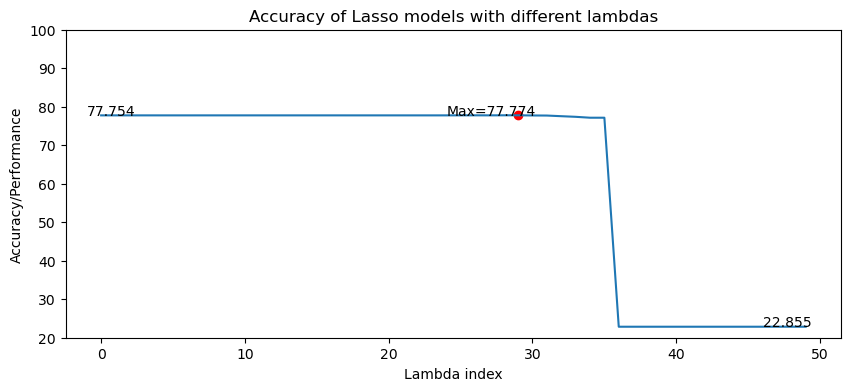

Lambda values: ['10^10.0', '10^9.798', '10^9.596', '10^9.394'...'10^-9.394', '10^-9.596', '10^-9.798', '10^-10.0']
Max accuracy: Lambda = 0.014563484775012445  accuracy: 77.7744224671599


In [17]:
# Plot performances:
plt.figure(figsize=(10, 4))
plt.ylim([20, 100])
plt.plot(range(len(lambdas)), accuracy_lambdas)
plt.scatter(max_acc_index, max_accuracy,  color="red") # Max accuracy point

plt.text(0-1, accuracy_lambdas[0]+0.05, str(round(accuracy_lambdas[0], 3)))
plt.text(max_acc_index-5, accuracy_lambdas[max_acc_index]+0.05, 'Max='+str(round(accuracy_lambdas[max_acc_index], 3)))
plt.text(len(lambdas)-4, accuracy_lambdas[len(lambdas)-1]+0.05, str(round(accuracy_lambdas[len(lambdas)-1], 3)))

plt.title("Accuracy of Lasso models with different lambdas")
plt.xlabel("Lambda index")
plt.ylabel("Accuracy/Performance")
plt.show()

output_str = list(map(lambda x: '10^' + str(x), np.linspace(10, -10, 100).round(3)))
print('Lambda values: ' + str(output_str[0:4])[:-1] + '...' + str(output_str[len(output_str)-4 : len(output_str)])[1:])
print('Max accuracy: Lambda = ' + str(lambdas[max_acc_index]) + '  accuracy: ' + str(accuracy_lambdas[max_acc_index]))

#### Fitting the model and finding the top 5 most important features

In [18]:
# Fitting the model for optimum lambda
optimum_lambda = lambdas[max_acc_index]
lasso.set_params(C = optimum_lambda)
lasso.fit(training_set_X, training_set_Y)

# Finding the top 5 most important features:
weights = np.abs(lasso.coef_[0].tolist()).tolist()
aux = copy.deepcopy(weights)
important_features_lasso = []

for i in range(5):
    max_value = max(aux)
    max_value_index= weights.index(max_value)
    print('Feature: ' + str(max_value_index) + '  Weight: ' + str(max_value))

    important_features_lasso.append(max_value_index)
    del aux[aux.index(max_value)]

# Get the original feature names instead of plain numbers:
important_features_lasso_names = list(map(lambda x: feature_names[x], important_features_lasso))
print("\nMost important features: " + str(important_features_lasso_names))

Feature: 4  Weight: 0.3384363411344164
Feature: 1  Weight: 0.190372442974819
Feature: 13  Weight: 0.15447653152651578
Feature: 16  Weight: 0.15257078947458586
Feature: 0  Weight: 0.14359328242964037

Most important features: ['sub_grade', 'term', 'dti', 'fico_range_low', 'loan_amnt']


## Elastic Net regression

#### Finding the best lambda

In [19]:
elasticNet = LogisticRegression(penalty='elasticnet', fit_intercept=True, max_iter=500, solver='saga', l1_ratio=0.5)

lambdas = 10**np.linspace(10, -10, 50) # 10 to the power of 100 evenly spaced numbers over [10, -2]
accuracy_lambdas = [] # accuracy of predictions for each lambda
max_accuracy = 0; max_acc_index = 0

for idx, l in enumerate(lambdas):
    elasticNet.set_params(C = l)
    elasticNet.fit(training_set_X, training_set_Y)
    predictions = (elasticNet.predict(training_set_X) >= 0.5).astype(int)  # if prediction > 0.5 round it to 1, else to 0

    acc = (1 - zero_one_loss(training_set_Y, predictions)) * 100    # get the sum of correctly classified objects
    accuracy_lambdas.append(acc)

    [max_accuracy, max_acc_index] = [acc, idx] if acc>max_accuracy else [max_accuracy, max_acc_index] # Keep track of max accuracy

print('Accurracy for each lambda: ' + str(accuracy_lambdas[0:2])[:-1] + '...' + str(accuracy_lambdas[len(accuracy_lambdas)-2 : len(accuracy_lambdas)])[1:])
print('Max accuracy: Lambda = ' + str(lambdas[max_acc_index]) + '  accuracy: ' + str(accuracy_lambdas[max_acc_index]))

Accurracy for each lambda: [77.75285261318781, 77.75285261318781...77.14458273117492, 77.14458273117492]
Max accuracy: Lambda = 0.09540954763499924  accuracy: 77.76687301826966


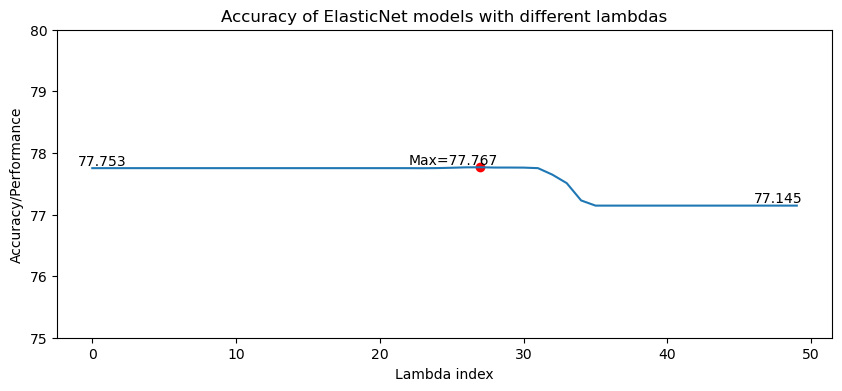

Lambda values: ['10^10.0', '10^9.798', '10^9.596', '10^9.394'...'10^-9.394', '10^-9.596', '10^-9.798', '10^-10.0']
Max accuracy: Lambda = 0.09540954763499924  accuracy: 77.76687301826966


In [20]:
# Plot performances:
plt.figure(figsize=(10, 4))
plt.ylim([75, 80])
plt.plot(range(len(lambdas)), accuracy_lambdas)
plt.scatter(max_acc_index, max_accuracy,  color="red") # Max accuracy point

plt.text(0-1, accuracy_lambdas[0]+0.05, str(round(accuracy_lambdas[0], 3)))
plt.text(max_acc_index-5, accuracy_lambdas[max_acc_index]+0.05, 'Max='+str(round(accuracy_lambdas[max_acc_index], 3)))
plt.text(len(lambdas)-4, accuracy_lambdas[len(lambdas)-1]+0.05, str(round(accuracy_lambdas[len(lambdas)-1], 3)))

plt.title("Accuracy of ElasticNet models with different lambdas")
plt.xlabel("Lambda index")
plt.ylabel("Accuracy/Performance")
plt.show()

output_str = list(map(lambda x: '10^' + str(x), np.linspace(10, -10, 100).round(3)))
print('Lambda values: ' + str(output_str[0:4])[:-1] + '...' + str(output_str[len(output_str)-4 : len(output_str)])[1:])
print('Max accuracy: Lambda = ' + str(lambdas[max_acc_index]) + '  accuracy: ' + str(accuracy_lambdas[max_acc_index]))

#### Fitting the model and finding the top 5 most important features

In [21]:
# Fitting the model for optimum lambda
optimum_lambda = lambdas[max_acc_index]
elasticNet.set_params(C = optimum_lambda)
elasticNet.fit(training_set_X, training_set_Y)

# Finding the top 5 most important features:
weights = np.abs(elasticNet.coef_[0].tolist()).tolist()
aux = copy.deepcopy(weights)
important_features_elastic = []

for i in range(5):
    max_value = max(aux)
    max_value_index= weights.index(max_value)
    print('Feature: ' + str(max_value_index) + '  Weight: ' + str(max_value))

    important_features_elastic.append(max_value_index)
    del aux[aux.index(max_value)]

# Get the original feature names instead of plain numbers:
important_features_elastic_names = list(map(lambda x: feature_names[x], important_features_elastic))
print("\nMost important features: " + str(important_features_elastic_names))

Feature: 4  Weight: 0.30899351573529626
Feature: 1  Weight: 0.19825147127654313
Feature: 13  Weight: 0.16527673029978646
Feature: 15  Weight: 0.15941060852586297
Feature: 0  Weight: 0.15744600656054752

Most important features: ['sub_grade', 'term', 'dti', 'earliest_cr_line', 'loan_amnt']


## Table with  the best features of each model

In [22]:
table_dictionary = {'Model':['Ridge', 'Lasso', 'ElasticNet'], 'Feature nr.1':[important_features_ridge_names[0], important_features_lasso_names[0], important_features_elastic_names[0]],
                    'Feature nr.2':[important_features_ridge_names[1], important_features_lasso_names[1], important_features_elastic_names[1]],
                    'Feature nr.3':[important_features_ridge_names[2], important_features_lasso_names[2], important_features_elastic_names[2]],
                    'Feature nr.4':[important_features_ridge_names[3], important_features_lasso_names[3], important_features_elastic_names[3]],
                    'Feature nr.5':[important_features_ridge_names[4], important_features_lasso_names[4], important_features_elastic_names[4]]}

best_features_table = pd.DataFrame(table_dictionary)

best_features_table

,Model,Feature nr.1,Feature nr.2,Feature nr.3,Feature nr.4,Feature nr.5
0,Ridge,term,sub_grade,dti,loan_amnt,fico_range_low
1,Lasso,sub_grade,term,dti,fico_range_low,loan_amnt
2,ElasticNet,sub_grade,term,dti,earliest_cr_line,loan_amnt


## Model comparison

In [23]:
pd.set_option('display.expand_frame_repr', False)  # printing dataframe width limit

# Function to use for confidence matrix and roc curve:
def conf_matrix_and_roc(predict_prob, thresholds):
    # DF to store results:
    results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "true pos rate", "true neg rate", "false pos rate", "false negative rate", "precision", "f-score", "AUC-score"])
    roc_points = np.zeros((len(thresholds), 2))

    for idx, i in enumerate(thresholds):

        # If prob for test set > threshold predict 1
        preds = np.where(predict_prob > i, 1, 0)

        # create confusion matrix [[TN, FP], [FN, TP]]
        cm = (confusion_matrix(test_set_Y, preds,labels=[0, 1], sample_weight=None) / len(test_set_Y))

        print('Confusion matrix for threshold =',i, '\n', cm, '\n')

        TN, FP, FN, TP = cm.ravel()

        # DF to store results:
        fpr = FP/(FP+TN); tpr = recall_score(test_set_Y, preds);
        results['THRESHOLD'] = thresholds
        results.iloc[idx,1] = accuracy_score(test_set_Y, preds)
        results.iloc[idx,2] = tpr                                                                                # True positive rate
        results.iloc[idx,3] = TN/(FP+TN)                                                                         # True negative rate
        results.iloc[idx,4] = fpr                                                                                # False positive rate
        results.iloc[idx,5] = FN/(FN+TP)                                                                        # False negative rate
        results.iloc[idx,6] = precision_score(test_set_Y, preds)
        results.iloc[idx,7] = f1_score(test_set_Y, preds)
        results.iloc[idx, 8] = roc_auc_score(test_set_Y, preds)  # AUC score

        # Markers on the roc plot
        roc_points[idx, 0] = fpr
        roc_points[idx, 1] = tpr


    print('ALL METRICS')
    print( results.T)

    # Plot ROC and compute AUC: (part of code taken from the book)
    ns_prob=[0 for _ in range(len(test_set_Y))]
    ns_fpr,ns_tpr,_=roc_curve(test_set_Y,ns_prob)
    lr_fpr,lr_tpr,_=roc_curve(test_set_Y, predict_prob)

    plt.plot(ns_fpr,ns_tpr,linestyle='--',label='Random Prediction')
    plt.plot(lr_fpr,lr_tpr,marker='.',label='Regression Model')

    for idx, t in enumerate(thresholds):
        if idx == 0:
            plt.scatter(roc_points[idx, 0], roc_points[idx, 1], color='green', s=50, marker='x', zorder=2, label='Thresholds')
        else:
            plt.scatter(roc_points[idx, 0], roc_points[idx, 1], color='green', s=50, marker='x', zorder=2)
        plt.text(roc_points[idx, 0] - 0.02, roc_points[idx, 1]+0.02, str(thresholds[idx]))

    plt.title('ROC curve')
    plt.grid(False)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    return

#### Confidence matrix and ROC curve for Ridge:

Confusion matrix for threshold = 0.5 
 [[0.03115406 0.19822336]
 [0.02257285 0.74804973]] 

Confusion matrix for threshold = 0.6 
 [[0.05815592 0.1712215 ]
 [0.0561679  0.71445468]] 

Confusion matrix for threshold = 0.7 
 [[0.10423272 0.1251447 ]
 [0.13823041 0.63239217]] 

Confusion matrix for threshold = 0.75 
 [[0.13586492 0.09351251]
 [0.21679501 0.55382757]] 

Confusion matrix for threshold = 0.8 
 [[0.17076853 0.05860889]
 [0.32814938 0.4424732 ]] 

Confusion matrix for threshold = 0.85 
 [[0.19978358 0.02959384]
 [0.46831748 0.3023051 ]] 

ALL METRICS
                            0         1         2         3         4         5
THRESHOLD                 0.5       0.6       0.7      0.75       0.8      0.85
accuracy             0.779204  0.772611  0.736625  0.689692  0.613242  0.502089
true pos rate        0.970708  0.927114  0.820625  0.718676  0.574176  0.392287
true neg rate         0.13582  0.253538  0.454416   0.59232  0.744487  0.870982
false pos rate        0.86418  0.7

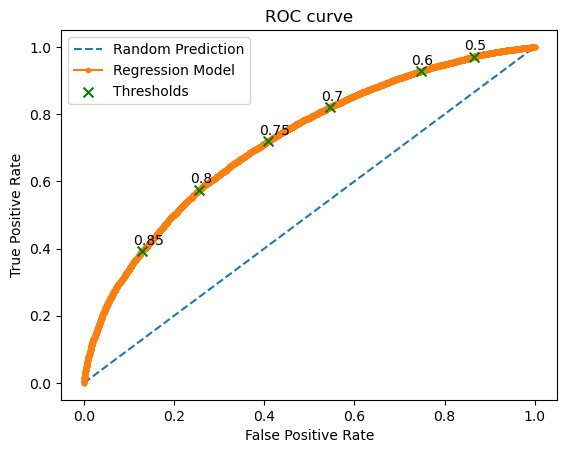

In [24]:
conf_matrix_and_roc(predict_prob = ridge.predict_proba(test_set_X)[:,1], thresholds=[.5, .6, .7, .75, .80, .85])

#### Confidence matrix and ROC curve for Lasso:

Confusion matrix for threshold = 0.5 
 [[0.03085208 0.19852534]
 [0.02184307 0.74877951]] 

Confusion matrix for threshold = 0.6 
 [[0.05840757 0.17096985]
 [0.05601691 0.71460567]] 

Confusion matrix for threshold = 0.7 
 [[0.1041069  0.12527052]
 [0.139237   0.63138558]] 

Confusion matrix for threshold = 0.75 
 [[0.1365947  0.09278273]
 [0.21777644 0.55284614]] 

Confusion matrix for threshold = 0.8 
 [[0.17152348 0.05785394]
 [0.33059037 0.44003221]] 

Confusion matrix for threshold = 0.85 
 [[0.20038754 0.02898988]
 [0.47392924 0.29669334]] 

ALL METRICS
                            0         1         2         3         4         5
THRESHOLD                 0.5       0.6       0.7      0.75       0.8      0.85
accuracy             0.779632  0.773013  0.735492  0.689441  0.611556  0.497081
true pos rate        0.971655   0.92731  0.819319  0.717402  0.571009  0.385005
true neg rate        0.134504  0.254635  0.453867  0.595502  0.747778  0.873615
false pos rate       0.865496  0.7

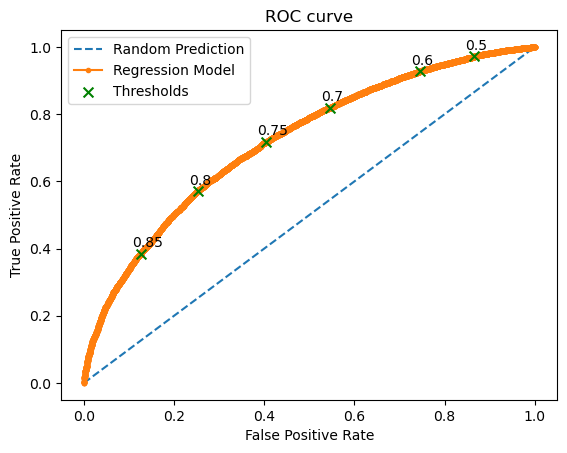

In [25]:
conf_matrix_and_roc(predict_prob = lasso.predict_proba(test_set_X)[:,1], thresholds=[.5, .6, .7, .75, .80, .85])

#### Confidence matrix and ROC curve for Elastic Net:

Confusion matrix for threshold = 0.5 
 [[0.03145604 0.19792139]
 [0.02277417 0.74784841]] 

Confusion matrix for threshold = 0.6 
 [[0.05961548 0.16976194]
 [0.05747647 0.71314611]] 

Confusion matrix for threshold = 0.7 
 [[0.10508833 0.12428909]
 [0.13953898 0.6310836 ]] 

Confusion matrix for threshold = 0.75 
 [[0.13634305 0.09303438]
 [0.21727314 0.55334944]] 

Confusion matrix for threshold = 0.8 
 [[0.17034073 0.05903669]
 [0.32716795 0.44345463]] 

Confusion matrix for threshold = 0.85 
 [[0.19885248 0.03052494]
 [0.46464341 0.30597916]] 

ALL METRICS
                            0         1         2         3         4         5
THRESHOLD                 0.5       0.6       0.7      0.75       0.8      0.85
accuracy             0.779304  0.772762  0.736172  0.689692  0.613795  0.504832
true pos rate        0.970447  0.925416  0.818927  0.718055   0.57545  0.397055
true neg rate        0.137137  0.259901  0.458146  0.594405  0.742622  0.866923
false pos rate       0.862863  0.7

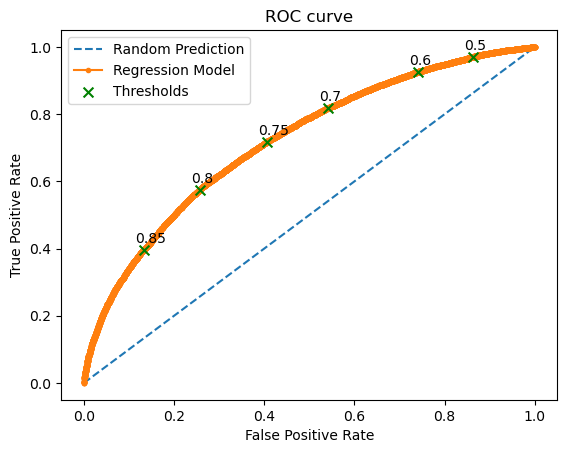

In [26]:
conf_matrix_and_roc(predict_prob = elasticNet.predict_proba(test_set_X)[:,1], thresholds=[.5, .6, .7, .75, .80, .85])

#### This shows that the roc curves are almost the same for all 3 models:

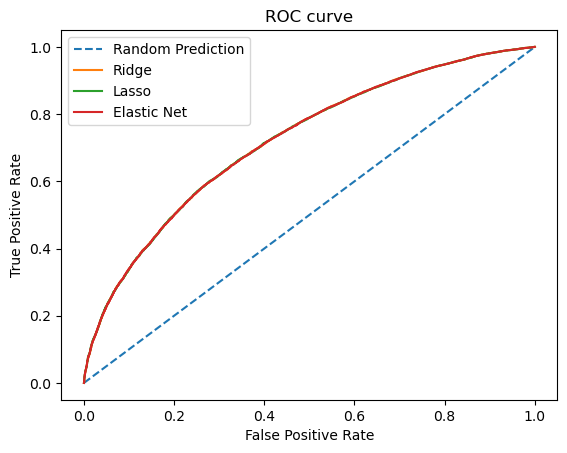

In [27]:
test_ridge_proba = ridge.predict_proba(test_set_X)[:,1]
test_lasso_proba = lasso.predict_proba(test_set_X)[:,1]
test_elasticNet_proba = elasticNet.predict_proba(test_set_X)[:,1]

ns_prob=[0 for _ in range(len(test_set_Y))]
ns_fpr,ns_tpr,_=roc_curve(test_set_Y,ns_prob)

lr_fpr_ridge,lr_tpr_ridge,_=roc_curve(test_set_Y,test_ridge_proba)
lr_fpr_lasso,lr_tpr_lasso,_=roc_curve(test_set_Y,test_lasso_proba)
lr_fpr_elasticNet,lr_tpr_elasticNet,_=roc_curve(test_set_Y,test_elasticNet_proba)

plt.plot(ns_fpr,ns_tpr,linestyle='--',label='Random Prediction')
plt.plot(lr_fpr_ridge,lr_tpr_ridge,label='Ridge')
plt.plot(lr_fpr_lasso,lr_tpr_lasso,label='Lasso')
plt.plot(lr_fpr_elasticNet,lr_tpr_elasticNet,label='Elastic Net')

plt.title('ROC curve')
plt.grid(False)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### Comparing the 3 models:

In [28]:
thresholds=[.5, .6, .7, .75, .80, .85]
auc_results = pd.DataFrame(columns = ['Threshold', 'Ridge', 'Lasso', 'ElasticNet'])
auc_results['Threshold'] = thresholds

for idx, t in enumerate(thresholds):
    auc_results.iloc[idx,1] = roc_auc_score(test_set_Y, np.where(test_ridge_proba > t, 1, 0))  # ridge auc
    auc_results.iloc[idx,2] = roc_auc_score(test_set_Y, np.where(test_lasso_proba > t, 1, 0))   # lasso auc
    auc_results.iloc[idx,3] = roc_auc_score(test_set_Y, np.where(test_elasticNet_proba > t, 1, 0))  #elasticNet auc

print("AUC comparison for different thresholds:")
print(auc_results.T)

AUC comparison for different thresholds:
                   0         1         2         3         4         5
Threshold        0.5       0.6       0.7      0.75       0.8      0.85
Ridge       0.553264  0.590326   0.63752  0.655498  0.659332  0.631634
Lasso       0.553079  0.590972  0.636593  0.656452  0.659394   0.62931
ElasticNet  0.553792  0.592658  0.638536   0.65623  0.659036  0.631989


In [29]:
thresholds=[.5, .6, .7, .75, .80, .85]
accuracy_results = pd.DataFrame(columns = ['Threshold', 'Ridge', 'Lasso', 'ElasticNet'])
accuracy_results['Threshold'] = thresholds

for idx, t in enumerate(thresholds):
    accuracy_results.iloc[idx,1] = accuracy_score(test_set_Y, np.where(test_ridge_proba > t, 1, 0))  # ridge accuracy
    accuracy_results.iloc[idx,2] = accuracy_score(test_set_Y, np.where(test_lasso_proba > t, 1, 0))   # lasso accuracy
    accuracy_results.iloc[idx,3] = accuracy_score(test_set_Y, np.where(test_elasticNet_proba > t, 1, 0))  #elasticNet accuracy

print("Acurracy comparison for different thresholds:")
print(accuracy_results.T)

Acurracy comparison for different thresholds:
                   0         1         2         3         4         5
Threshold        0.5       0.6       0.7      0.75       0.8      0.85
Ridge       0.779204  0.772611  0.736625  0.689692  0.613242  0.502089
Lasso       0.779632  0.773013  0.735492  0.689441  0.611556  0.497081
ElasticNet  0.779304  0.772762  0.736172  0.689692  0.613795  0.504832
